# Processing of IC50 files of similar proteins to TIGIT

### Script based on Natália scripts

# P12821

In [1]:
#Imports

import pandas as pd
import numpy as np
#from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import molvs
from molvs import Standardizer
from molvs import fragment
from molvs import charge
from molvs import tautomer
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric, GetScaffoldForMol
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.rdinchi import InchiToInchiKey, MolToInchi
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdFMCS
from rdkit.Chem.Draw import DrawingOptions
from IPython.display import SVG
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
#import pubchempy
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
from scipy import stats

In [2]:
#Reading each file

activities = pd.read_csv("LigandsChEMBL_IC50__Uniprot_P12821_PDB_1O86_PminHighest.csv", sep=";")

assays = pd.read_csv("AssaysChEMBL_Uniprot_P12821_PDB_1O86_PminHighest.csv", sep=";")

activities.shape, assays.shape

((843, 46), (215, 31))

In [3]:
assays.columns

Index(['ChEMBL ID', 'Assay Type', 'Description', 'Organism', 'Compounds',
       'Activities', 'BAO Format ID', 'BAO Format', 'Confidence Score',
       'Confidence Label', 'Strain', 'Source', 'Tax ID', 'Tissue ChEMBL ID',
       'Tissue Name', 'Cell Type', 'Subcellular Fraction',
       'Document ChEMBL ID', 'PubMed ID', 'DOI', 'Year', 'Journal', 'Volume',
       'First Page', 'Last Page', 'Assay Parameters',
       'Assay Classification L1', 'Assay Classification L2',
       'Assay Classification L3', 'Variant Sequence Accession',
       'Variant Sequence Mutation'],
      dtype='object')

In [4]:
#Only Assays with a ChEMBL ID will be accepted

accepted_assays = assays["ChEMBL ID"]

In [5]:
#Only rows from "activities" whose ChEMBL ID is present in "accepted_assays" will be accepted 

accepted_rows_where = np.in1d(activities['Assay ChEMBL ID'], accepted_assays)
activities = activities[accepted_rows_where]
activities.shape

(707, 46)

In [6]:
print(sum(accepted_rows_where), "accepted bioactivies")

707 accepted bioactivies


In [7]:
# Are all smiles valid? if not we need to remove the invalid entries
if activities["Smiles"].notnull().all() == False:
    valid_smiles = activities["Smiles"].notnull()
    print(sum(~valid_smiles), "removed lines")
    activities = activities[valid_smiles]

In [8]:
# See if RDKit can understand all SMILES
valid_smiles=[]

for smi in activities["Smiles"]:
    try:
        mol = Chem.MolFromSmiles(smi)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        valid_smiles.append(True)
    except:
        valid_smiles.append(False)

valid_smiles = np.array(valid_smiles)
print(sum(~valid_smiles), "removed lines")
activities = activities[valid_smiles]

0 removed lines


In [9]:
# Next I could standardise the molecules but, because this is an expensive step, I will try to narrow down the
# dataset via activity types filtration
activities['Standard Type'].unique()

array(['IC50'], dtype=object)

In [10]:
# I will only use IC50 and Ki as I am interested in inhibitors
accept_rows = np.in1d(activities['Standard Type'], ['IC50'])
activities = activities[accept_rows]
activities.shape

(707, 46)

In [11]:
# Next I can filter out line with not mathematical relationship 
# One entry could be IC50 < 100 or IC50 > 100, we don't know...
activities['Standard Relation'].unique()

array(["'='", nan, "'>'"], dtype=object)

In [12]:
#Only with equals

accept_rows = np.in1d(activities['Standard Relation'], ["'='"])
activities = activities[accept_rows]
activities.shape

(623, 46)

In [13]:
# filter by unit to keep only units that are convertible into nM
activities['Standard Units'].unique()

array(['nM'], dtype=object)

### Note:
if you have other molar units, you should remove those entries, in order to keep only activites expressed in nM **FOR LOGISTICAL REASONS ONLY**. Other units are as valid as nM

In [14]:
activities = activities[activities['Standard Units']=="nM"]

# Standardizar moléculas

In [15]:
def standardize_molecules(smiles_list):
    unsalt = molvs.fragment.LargestFragmentChooser()
    s = Standardizer()
    u = molvs.charge.Uncharger()
    t = molvs.tautomer.TautomerCanonicalizer()
    std_smi = []
    inchik = []
    for smi in smiles_list:
        m = Chem.MolFromSmiles(smi)
        # step 1: sanitize, disconect metals, normalise chemotypes, reionise acids
        m = s.standardize(m)
        # step 2: disconect salts
        m = unsalt(m)
        # step 3: neutralise
        m = u.uncharge(m)
        # step 4: tautomer canolinaliser
        # m = t.canonicalize(m)
        inchik.append(Chem.MolToInchiKey(m))
        std_smi.append(Chem.MolToSmiles(m))
    return(inchik, std_smi)

### An example ...

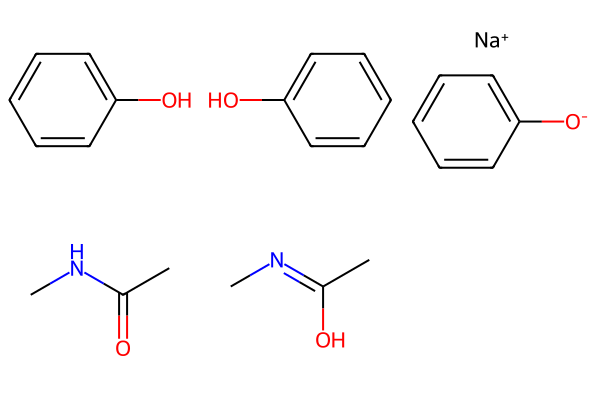

In [16]:
# These 5 compounds are actually just 2. As they are now, it is impossible for me to identify them as duplicates
# particularly on a large scale

compounds = ["c1ccccc1O", "c1cc(O)ccc1", "c1ccccc1[O-].[Na+]", "CNC(C)=O", "CN=C(C)O"]

mols = []
for compound in compounds:
    mols.append(Chem.MolFromSmiles(compound))
    
Draw.MolsToGridImage(mols)

In [17]:
inchikey,std_mols = standardize_molecules(compounds)

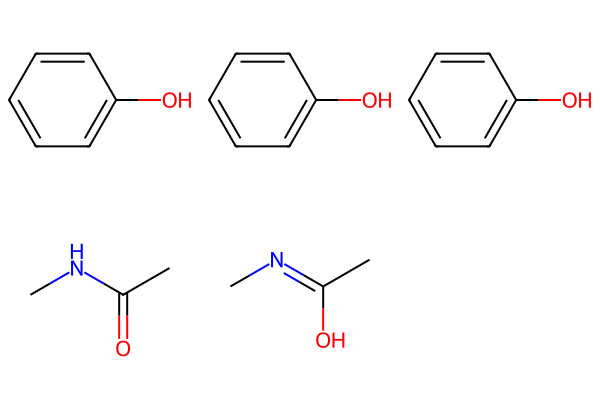

In [18]:
mols = []
for compound in std_mols:
    mols.append(Chem.MolFromSmiles(compound))
    
Draw.MolsToGridImage(mols)

In [19]:
inchikey

['ISWSIDIOOBJBQZ-UHFFFAOYSA-N',
 'ISWSIDIOOBJBQZ-UHFFFAOYSA-N',
 'ISWSIDIOOBJBQZ-UHFFFAOYSA-N',
 'OHLUUHNLEMFGTQ-UHFFFAOYSA-N',
 'OHLUUHNLEMFGTQ-UHFFFAOYSA-N']

### Agora com os nossos dados

In [20]:
inchikeys,std_mols = standardize_molecules(activities["Smiles"])

# add the two columns to the dataset
activities.loc[:,"SMILES_std"] = std_mols
activities.loc[:,"inchikeys"] = inchikeys

In [21]:
#inspect uniques
np.unique(std_mols).shape, np.unique(inchikeys).shape

((525,), (525,))

In [22]:
activities.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties',
       'Action Type', 'SMILES_std', 'inchikeys'

In [23]:
# Because my ultimate goal is to build a ML classifier, I need to binarise the output variable
# As a result, having the sign "<" with values above my cutoff, or having the sign ">" with values below my cutoff
# makes no sense, so I should remove those

activity_cutoff = 1000 # nM
is_larger = np.in1d(activities['Standard Relation'], ["'>'", "'>='"]) 
is_smaller = np.in1d(activities['Standard Relation'], ["'<'", "'<='"])

lines2remove = ~np.logical_and(is_larger, activities['Standard Value'] < activity_cutoff)
activities=activities[lines2remove]

lines2remove = ~np.logical_and(is_smaller, activities['Standard Value'] > activity_cutoff)
activities=activities[lines2remove]

In [24]:
activities.shape

(623, 48)

In [25]:
# Now that all lines are acceptable and comparable we can finally de-duplicate
# As we saw in earlier labs, we should first order the compounds by most to least active
# Because the drop_duplicates() function keeps the first by default
activities = activities.sort_values('Standard Value', ascending=True).drop_duplicates("inchikeys")
activities.shape

(525, 48)

In [26]:
# An example on how splitting into classes works
myclasses = pd.cut([1,2,3,7,10,5,4], [0,5,11], labels=["class1", "class2"])
myclasses = list(myclasses)
myclasses

['class1', 'class1', 'class1', 'class2', 'class2', 'class1', 'class1']

In [27]:
# split compounds into 2 classes
act_class = pd.cut(activities["Standard Value"], [0,1000,activities["Standard Value"].max()+1] ,labels = ["active", "inactive"])
activities.loc[:,"act_class"] = list(act_class)

In [28]:
activities

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,SMILES_std,inchikeys,act_class
583,CHEMBL443353,NaN,NaN,367.54,0.0,3.32,3c,C[C@H](CS)C(=O)N1[C@@H](SCCCc2ccccc2)CC[C@H]1C...,IC50,'=',...,1,Scientific Literature,Bioorg Med Chem Lett,2008,NaN,NaN,NaN,C[C@H](CS)C(=O)N1[C@@H](SCCCc2ccccc2)CC[C@H]1C...,CGPUJSIVRWHBDZ-KBMXLJTQSA-N,active
760,CHEMBL1237,LISINOPRIL,4.0,405.50,0.0,1.24,Lisinopril,NCCCC[C@H](N[C@@H](CCc1ccccc1)C(=O)O)C(=O)N1CC...,IC50,'=',...,1,Scientific Literature,J Med Chem,2003,NaN,NaN,NaN,NCCCC[C@H](N[C@@H](CCc1ccccc1)C(=O)O)C(=O)N1CC...,RLAWWYSOJDYHDC-BZSNNMDCSA-N,active
821,CHEMBL289556,OMAPATRILAT,-1.0,408.55,0.0,1.94,Omapatrilat,O=C(N[C@H]1CCS[C@H]2CCC[C@@H](C(=O)O)N2C1=O)[C...,IC50,'=',...,1,Scientific Literature,ACS Med Chem Lett,2019,NaN,NaN,NaN,O=C(N[C@H]1CCS[C@H]2CCC[C@@H](C(=O)O)N2C1=O)[C...,LVRLSYPNFFBYCZ-VGWMRTNUSA-N,active
416,CHEMBL198316,NaN,NaN,438.55,0.0,2.78,84,O=C(N[C@H]1Cc2ccccc2C2CCC[C@H](C(=O)O)N2C1=O)[...,IC50,'=',...,1,Scientific Literature,J Med Chem,2005,NaN,NaN,NaN,O=C(N[C@H]1Cc2ccccc2C2CCC[C@H](C(=O)O)N2C1=O)[...,RIWRWPXUDHZKIO-AJQVQDMVSA-N,active
625,CHEMBL1560,CAPTOPRIL,4.0,217.29,0.0,0.63,Captopril,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O,IC50,'=',...,1,Scientific Literature,Bioorg Med Chem Lett,2009,NaN,NaN,NaN,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,CHEMBL90074,NaN,NaN,218.21,0.0,-1.23,EA,C[C@H](NC(=O)[C@@H](N)CCC(=O)O)C(=O)O,IC50,'=',...,1,Scientific Literature,J Med Chem,1995,NaN,NaN,NaN,C[C@H](NC(=O)[C@@H](N)CCC(=O)O)C(=O)O,JZDHUJAFXGNDSB-WHFBIAKZSA-N,inactive
24,CHEMBL421171,NaN,NaN,190.16,0.0,-2.01,DG,N[C@@H](CC(=O)O)C(=O)NCC(=O)O,IC50,'=',...,1,Scientific Literature,J Med Chem,1995,NaN,NaN,NaN,N[C@@H](CC(=O)O)C(=O)NCC(=O)O,JHFNSBBHKSZXKB-VKHMYHEASA-N,inactive
146,CHEMBL59426,NaN,NaN,172.18,0.0,-1.06,PG,O=C(O)CNC(=O)[C@@H]1CCCN1,IC50,'=',...,1,Scientific Literature,J Med Chem,1995,NaN,NaN,NaN,O=C(O)CNC(=O)[C@@H]1CCCN1,RNKSNIBMTUYWSH-YFKPBYRVSA-N,inactive
417,CHEMBL38405,NaN,NaN,253.32,0.0,1.12,29d,O=C(O)CC(=O)NC(CS)Cc1ccccc1,IC50,'=',...,1,Scientific Literature,J Med Chem,1997,NaN,NaN,NaN,O=C(O)CC(=O)NC(CS)Cc1ccccc1,REPVVNYZORKKPQ-UHFFFAOYSA-N,inactive


In [29]:
activities["SMILES_std"].to_csv("P12821_curated_dataset.csv", sep="\t")

# ----------------------------------------

### Q9NUW8

In [30]:
#Reading each file

activities = pd.read_csv("LigandsChEMBL_IC50_Uniprot_Q9NUW8_PDB_1MU7_PmaxHighest.csv", sep=";")

assays = pd.read_csv("AssaysChEMBL_Uniprot_Q9NUW8_PDB_1MU7_PmaxHighest.csv", sep=";")

activities.shape, assays.shape

((632, 46), (99, 31))

In [31]:
assays.columns
#Only Assays with a ChEMBL ID will be accepted

accepted_assays = assays["ChEMBL ID"]

In [32]:
#Only rows from "activities" whose ChEMBL ID is present in "accepted_assays" will be accepted 

accepted_rows_where = np.in1d(activities['Assay ChEMBL ID'], accepted_assays)
activities = activities[accepted_rows_where]
activities.shape

(632, 46)

In [33]:
print(sum(accepted_rows_where), "accepted bioactivies")

632 accepted bioactivies


In [34]:
# Are all smiles valid? if not we need to remove the invalid entries
if activities["Smiles"].notnull().all() == False:
    valid_smiles = activities["Smiles"].notnull()
    print(sum(~valid_smiles), "removed lines")
    activities = activities[valid_smiles]

1 removed lines


In [35]:
# See if RDKit can understand all SMILES
valid_smiles=[]

for smi in activities["Smiles"]:
    try:
        mol = Chem.MolFromSmiles(smi)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        valid_smiles.append(True)
    except:
        valid_smiles.append(False)

valid_smiles = np.array(valid_smiles)
print(sum(~valid_smiles), "removed lines")
activities = activities[valid_smiles]

0 removed lines


In [36]:
# Next I could standardise the molecules but, because this is an expensive step, I will try to narrow down the
# dataset via activity types filtration
activities['Standard Type'].unique()

array(['IC50'], dtype=object)

In [37]:
# I will only use IC50 and Ki as I am interested in inhibitors
accept_rows = np.in1d(activities['Standard Type'], ['IC50'])
activities = activities[accept_rows]
activities.shape

(631, 46)

In [38]:
# Next I can filter out line with not mathematical relationship 
# One entry could be IC50 < 100 or IC50 > 100, we don't know...
activities['Standard Relation'].unique()

array(["'>'", "'='", nan], dtype=object)

In [39]:
#Only with equals

accept_rows = np.in1d(activities['Standard Relation'], ["'='"])
activities = activities[accept_rows]
activities.shape

(406, 46)

In [40]:
# filter by unit to keep only units that are convertible into nM
activities['Standard Units'].unique()

array(['nM'], dtype=object)

In [41]:
activities = activities[activities['Standard Units']=="nM"]

In [42]:
def standardize_molecules(smiles_list):
    unsalt = molvs.fragment.LargestFragmentChooser()
    s = Standardizer()
    u = molvs.charge.Uncharger()
    t = molvs.tautomer.TautomerCanonicalizer()
    std_smi = []
    inchik = []
    for smi in smiles_list:
        m = Chem.MolFromSmiles(smi)
        # step 1: sanitize, disconect metals, normalise chemotypes, reionise acids
        m = s.standardize(m)
        # step 2: disconect salts
        m = unsalt(m)
        # step 3: neutralise
        m = u.uncharge(m)
        # step 4: tautomer canolinaliser
        # m = t.canonicalize(m)
        inchik.append(Chem.MolToInchiKey(m))
        std_smi.append(Chem.MolToSmiles(m))
    return(inchik, std_smi)

In [43]:
inchikeys,std_mols = standardize_molecules(activities["Smiles"])

# add the two columns to the dataset
activities.loc[:,"SMILES_std"] = std_mols
activities.loc[:,"inchikeys"] = inchikeys

In [44]:
#inspect uniques
np.unique(std_mols).shape, np.unique(inchikeys).shape

((312,), (312,))

In [45]:
activities.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties',
       'Action Type', 'SMILES_std', 'inchikeys'

In [46]:
# Because my ultimate goal is to build a ML classifier, I need to binarise the output variable
# As a result, having the sign "<" with values above my cutoff, or having the sign ">" with values below my cutoff
# makes no sense, so I should remove those

activity_cutoff = 1000 # nM
is_larger = np.in1d(activities['Standard Relation'], ["'>'", "'>='"]) 
is_smaller = np.in1d(activities['Standard Relation'], ["'<'", "'<='"])

lines2remove = ~np.logical_and(is_larger, activities['Standard Value'] < activity_cutoff)
activities=activities[lines2remove]

lines2remove = ~np.logical_and(is_smaller, activities['Standard Value'] > activity_cutoff)
activities=activities[lines2remove]

In [47]:
activities.shape

(406, 48)

In [48]:
# Now that all lines are acceptable and comparable we can finally de-duplicate
# As we saw in earlier labs, we should first order the compounds by most to least active
# Because the drop_duplicates() function keeps the first by default
activities = activities.sort_values('Standard Value', ascending=True).drop_duplicates("inchikeys")
activities.shape

(312, 48)

In [49]:
# An example on how splitting into classes works
myclasses = pd.cut([1,2,3,7,10,5,4], [0,5,11], labels=["class1", "class2"])
myclasses = list(myclasses)
myclasses

['class1', 'class1', 'class1', 'class2', 'class2', 'class1', 'class1']

In [50]:
# split compounds into 2 classes
act_class = pd.cut(activities["Standard Value"], [0,1000,activities["Standard Value"].max()+1] ,labels = ["active", "inactive"])
activities.loc[:,"act_class"] = list(act_class)

In [51]:
activities

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,SMILES_std,inchikeys,act_class
90,CHEMBL65,CAMPTOTHECIN,-1.0,348.36,0.0,2.08,1,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1,IC50,'=',...,1,Scientific Literature,J Med Chem,2017,NaN,NaN,NaN,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1,VSJKWCGYPAHWDS-FQEVSTJZSA-N,NaN
268,CHEMBL4464463,NaN,NaN,609.68,1.0,3.26,42; NF-SDM,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCN(CNc4ccc(S(=O...,IC50,'=',...,1,Scientific Literature,Bioorg Med Chem,2016,NaN,NaN,NaN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCN(CNc4ccc(S(=O...,RUBMSPWXSHZTRU-UHFFFAOYSA-N,active
502,CHEMBL4746230,NaN,NaN,507.61,2.0,6.20,9a,CC(=O)C1=C(O)C=C2Oc3c(-c4csc(/C=C(\C)CCC=C(C)C...,IC50,'=',...,1,Scientific Literature,J Nat Prod,2020,NaN,NaN,INHIBITOR,CC(=O)C1=C(O)C=C2Oc3c(-c4csc(/C=C(\C)CCC=C(C)C...,XYRHEOIBWUNZMZ-GGRWDMAWSA-N,active
431,CHEMBL275938,AURINTRICARBOXYLIC ACID,NaN,422.35,0.0,2.45,32,O=C(O)C1=CC(=C(c2ccc(O)c(C(=O)O)c2)c2ccc(O)c(C...,IC50,'=',...,1,Scientific Literature,Bioorg Med Chem,2016,NaN,NaN,NaN,O=C(O)C1=CC(=C(c2ccc(O)c(C(=O)O)c2)c2ccc(O)c(C...,GIXWDMTZECRIJT-UHFFFAOYSA-N,active
305,CHEMBL5187480,NaN,NaN,551.67,2.0,6.22,3b,CC(=O)C1=C(O)C=C2Oc3c(-c4csc(N/N=C/CC(C)CCC=C(...,IC50,'=',...,1,Scientific Literature,Bioorg Med Chem Lett,2022,NaN,NaN,INHIBITOR,CC(=O)C1=C(O)C=C2Oc3c(-c4csc(N/N=C/CC(C)CCC=C(...,QBQXWRMQBGVMLB-ZJZGQBIDSA-N,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,CHEMBL184618,FRAMYCETIN,3.0,614.65,3.0,-8.90,Neomycin B,NC[C@@H]1O[C@H](O[C@H]2[C@@H](O)[C@H](O[C@@H]3...,IC50,'=',...,1,Scientific Literature,J Med Chem,2012,NaN,NaN,NaN,NC[C@@H]1O[C@H](O[C@H]2[C@@H](O)[C@H](O[C@@H]3...,PGBHMTALBVVCIT-VCIWKGPPSA-N,inactive
269,CHEMBL3184512,CLINDAMYCIN PHOSPHATE,4.0,504.97,1.0,0.51,Clindamycin 2-phosphate,CCC[C@@H]1C[C@@H](C(=O)N[C@@H]([C@H]2O[C@H](SC...,IC50,'=',...,1,Scientific Literature,Bioorg Med Chem,2016,NaN,NaN,NaN,CCC[C@@H]1C[C@@H](C(=O)N[C@@H]([C@H]2O[C@H](SC...,UFUVLHLTWXBHGZ-MGZQPHGTSA-N,inactive
418,CHEMBL469912,PUROMYCIN,-1.0,471.52,1.0,-0.79,Puromycin,COc1ccc(C[C@H](N)C(=O)N[C@H]2[C@@H](O)[C@H](n3...,IC50,'=',...,1,Scientific Literature,Bioorg Med Chem,2016,NaN,NaN,NaN,COc1ccc(C[C@H](N)C(=O)N[C@H]2[C@@H](O)[C@H](n3...,RXWNCPJZOCPEPQ-NVWDDTSBSA-N,inactive
209,CHEMBL370143,PAROMOMYCIN,4.0,615.63,3.0,-8.86,24,NC[C@@H]1O[C@H](O[C@H]2[C@@H](O)[C@H](O[C@@H]3...,IC50,'=',...,1,Scientific Literature,Bioorg Med Chem,2016,NaN,NaN,NaN,NC[C@@H]1O[C@H](O[C@H]2[C@@H](O)[C@H](O[C@@H]3...,UOZODPSAJZTQNH-LSWIJEOBSA-N,inactive


In [52]:
activities["SMILES_std"].to_csv("Q9NUW8_curated_dataset.csv", sep="\t")